In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import json
import random
import time

In [2]:
import tensorflow as tf
from tensorflow.nn import dropout
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC' #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
config.gpu_options.per_process_gpu_memory_fraction = 0.3
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [3]:
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras.layers.recurrent import LSTM
from keras import optimizers
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTMCell
from keras.layers import RNN
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from tensorflow.keras.optimizers import Adam

In [43]:
### CULane Dataset

culane_dataset = []
files = []
#files.append(open('../../LaneNet_train_set/label_data_driver_23_30frame.json', 'r'))
files.append(open('../../LaneNet_train_set/label_data_driver_161_90frame.json', 'r'))
files.append(open('../../LaneNet_train_set/label_data_driver_182_30frame.json', 'r'))
for file in files:
    training_frames = []
    for line in file.readlines():
        training_frames.append(json.loads(line))
    culane_dataset.append(training_frames)
l1_dataset = []
l2_dataset = []
l3_dataset = []
l4_dataset = []
raw_file_dataset = []
for training_frames in culane_dataset:
    l1_list = []
    l2_list = []
    l3_list = []
    l4_list = []
    raw_file_list = []
    for f in training_frames:
        if len(f['lanes']) > 0:
            for ldx, l in enumerate(f['lanes']):
                if ldx == 0:
                    l1_list.append(l)
                    #l1_list.append(np.concatenate(([l], [f['h_samples']])).transpose())
                elif ldx == 1:
                    l2_list.append(l)
                    #l2_list.append(np.concatenate(([l], [f['h_samples']])).transpose())
                elif ldx == 2:
                    raw_file_list.append(f['raw_file'])
                    l3_list.append(l)
                    #l3_list.append(np.concatenate(([l], [f['h_samples']])).transpose())
                elif ldx == 3:
                    l4_list.append(l)
                    #l4_list.append(np.concatenate(([l], [f['h_samples']])).transpose())
    l1_dataset.append(l1_list)
    l2_dataset.append(l2_list)
    l3_dataset.append(l3_list)
    l4_dataset.append(l4_list)
    raw_file_dataset.append(raw_file_list)

data_x = []
data_y = []
data_file_name = []

for l3_list in l3_dataset:
    for l in range(len(l3_list) - 5):
        data_x.append(np.concatenate(([l3_list[l]], [l3_list[l + 1]], [l3_list[l + 2]], [l3_list[l + 3]], [l3_list[l + 4]])))
        data_y.append([l3_list[l + 5]])

for raw_file_list in raw_file_dataset:
    for l in range(len(raw_file_list) - 5):
        data_file_name.append(np.concatenate(([raw_file_list[l]], [raw_file_list[l + 1]], [raw_file_list[l + 2]], \
                                              [raw_file_list[l + 3]], [raw_file_list[l + 4]], [raw_file_list[l + 5]])))
        
    #break
#print(test_x[0])

print('Total {} features\' sequence frames.'.format(len(data_x)))
print('Total {} labels\' frames.'.format(len(data_y)))
print(np.array(data_x).shape)
print(np.array(data_y).shape)
data_x = np.array(data_x)
data_y = np.array(data_y)
data_file_name = np.array(data_file_name)

def extractor(arr):
    '''
    data = []
    for i in range(len(arr)):
        seq = []
        for j in range(len(arr[i])):
            tmp = arr[i, j, arr[i, j, :] != -2]
            
            
            if len(tmp) < 10:
                tmp = np.concatenate((tmp, [-2] * (10 - len(tmp))))
            else:
                print('-------------')
                origial_len = len(tmp)
                print(origial_len)
                #extract_offset = int(origial_len / 10)
                extract_offset = round(origial_len / 10)
                print(extract_offset)
                extract_idx = np.arange(0, origial_len, extract_offset)
                tmp = tmp[extract_idx]
                print(len(tmp))
                print('-------------')
            
            seq.append(tmp)
        seq = np.array(seq)
        data.append(seq)
    return np.array(data)
    '''
    origial_len = len(arr[0, 0, :])
    extract_offset = int((origial_len - 21) / 10)
    extract_idx = np.arange(21, origial_len, extract_offset)
    arr = arr[:, :, extract_idx]
    for i in range(len(arr)):
        for j in range(len(arr[i])):
            for k in range(1, len(arr[i, j])):
                if arr[i, j, k] == -2 and arr[i, j, k - 1] != -2:
                    arr[i, j, k] = arr[i, j, k - 1] + 10
                
            for k in range(len(arr[i, j]) - 1, 0, -1):
                if arr[i, j, k] != -2 and arr[i, j, k - 1] == -2:
                    arr[i, j, k - 1] = arr[i, j, k] - 10
    return arr

data_x = extractor(data_x).astype(float)
data_y = extractor(data_y).astype(float)
shuffled_idx = np.arange(0, len(data_x))
random.shuffle(shuffled_idx)
s1 = int(len(data_x) * 0.6)
s2 = int(len(data_x) * 0.9)
train_x = data_x[shuffled_idx[:s1]] / 1640
train_y = data_y[shuffled_idx[:s1]] / 1640
train_y = train_y.reshape((s1, 19))
train_file_name = data_file_name[shuffled_idx[:s1]]
val_x = data_x[shuffled_idx[s1:s2]] / 1640
val_y = data_y[shuffled_idx[s1:s2]] / 1640
val_y = val_y.reshape((s2 - s1, 19))
val_file_name = data_file_name[shuffled_idx[s1:s2]]
test_x = data_x[shuffled_idx[s2:]] / 1640
test_y = data_y[shuffled_idx[s2:]] / 1640
test_y = test_y.reshape((len(data_x) - s2, 19))
test_file_name = data_file_name[shuffled_idx[s2:]]

print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)
print(test_x.shape)
print(test_y.shape)


Total 29371 features' sequence frames.
Total 29371 labels' frames.
(29371, 5, 40)
(29371, 1, 40)
(17622, 5, 19)
(17622, 19)
(8811, 5, 19)
(8811, 19)
(2938, 5, 19)
(2938, 19)


In [44]:
#print(test_x[90])
#print(test_x[90].reshape((1, 5, 19)))

In [45]:
In = Input(shape = (5, 19))
In_top_point = Input(shape = (5, 1))
In_bot_point = Input(shape = (5, 1))

en_d1 = Dense(19, activation='linear')(In)
en_d1 = Dropout(0.5)(en_d1)
en_d2 = Dense(15, activation='linear')(en_d1)
en_d2 = Dropout(0.5)(en_d2)
en_d3 = Dense(10, activation='linear')(en_d2)
cells1 = [LSTMCell(10), LSTMCell(10), LSTMCell(10), LSTMCell(10), LSTMCell(10)]
lstm1 = RNN(cells1)(en_d3)
lstm1 = Dropout(0.5)(lstm1)
de_d1 = Dense(10, activation='linear')(lstm1)
de_d1 = Dropout(0.5)(de_d1)
de_d2 = Dense(15, activation='linear')(de_d1)
de_d2 = Dropout(0.5)(de_d2)
Out1 = Dense(19, activation='linear')(de_d2)

cells2 = [LSTMCell(1), LSTMCell(1)]
lstm2 = RNN(cells2)(In_top_point)
#Out2 = Dropout(0.2)(lstm2)
up2_d1 = Dense(10, activation='linear')(lstm2)
up2_d2 = Dense(19, activation='linear')(up2_d1)
Out2 = Dropout(0.2)(up2_d2)

cells3 = [LSTMCell(1), LSTMCell(1)]
lstm3 = RNN(cells3)(In_bot_point)
#Out3 = Dropout(0.2)(lstm3)
up3_d1 = Dense(10, activation='linear')(lstm3)
up3_d2 = Dense(19, activation='linear')(up3_d1)
Out3 = Dropout(0.2)(up3_d2)

Out = concatenate([Out1, Out2, Out3])
Out = Dense(19, activation='linear')(Out)

en_lstm_de_model_bs64 = Model(inputs = [In, In_top_point, In_bot_point], outputs = Out)
en_lstm_de_model_bs64.compile(loss = 'mse', optimizer = 'adam')

print(en_lstm_de_model_bs64.summary())

train_x_top = train_x[:, :, 0].reshape((len(train_x), 5, 1))
train_x_bot = train_x[:, :, -1].reshape((len(train_x), 5, 1))
val_x_top = val_x[:, :, 0].reshape((len(val_x), 5, 1))
val_x_bot = val_x[:, :, -1].reshape((len(val_x), 5, 1))

trained_lstm2 = en_lstm_de_model_bs64.fit([train_x, train_x_top, train_x_bot], train_y, \
                                          epochs = 250, batch_size = 64, validation_data = \
                                          ([val_x, val_x_top, val_x_bot], val_y), shuffle = False)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5, 19)        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 5, 19)        380         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 5, 19)        0           dense_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 5, 15)        300         dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

17622/17622 [==============================] - 15s 842us/step - loss: 0.0037 - val_loss: 0.0036
Epoch 100/250
17622/17622 [==============================] - 15s 840us/step - loss: 0.0037 - val_loss: 0.0036
Epoch 101/250
17622/17622 [==============================] - 15s 840us/step - loss: 0.0037 - val_loss: 0.0036
Epoch 102/250
17622/17622 [==============================] - 15s 842us/step - loss: 0.0037 - val_loss: 0.0036
Epoch 103/250
17622/17622 [==============================] - 15s 840us/step - loss: 0.0037 - val_loss: 0.0036
Epoch 104/250
17622/17622 [==============================] - 15s 837us/step - loss: 0.0037 - val_loss: 0.0036
Epoch 105/250
17622/17622 [==============================] - 15s 843us/step - loss: 0.0037 - val_loss: 0.0036
Epoch 106/250
17622/17622 [==============================] - 15s 836us/step - loss: 0.0037 - val_loss: 0.0036
Epoch 107/250
17622/17622 [==============================] - 15s 844us/step - loss: 0.0037 - val_loss: 0.0036
Epoch 108/250
17622/1762

17622/17622 [==============================] - 15s 842us/step - loss: 0.0037 - val_loss: 0.0037
Epoch 248/250
17622/17622 [==============================] - 15s 839us/step - loss: 0.0037 - val_loss: 0.0037
Epoch 249/250
17622/17622 [==============================] - 15s 839us/step - loss: 0.0037 - val_loss: 0.0037
Epoch 250/250
17622/17622 [==============================] - 15s 843us/step - loss: 0.0037 - val_loss: 0.0036


In [20]:
'''
en_lstm_de_model_bs64.save('en_lstm_de_model_bs64.h5')
plot_model(en_lstm_de_model_bs64, to_file = 'en_lstm_de_model_bs64.png')
'''

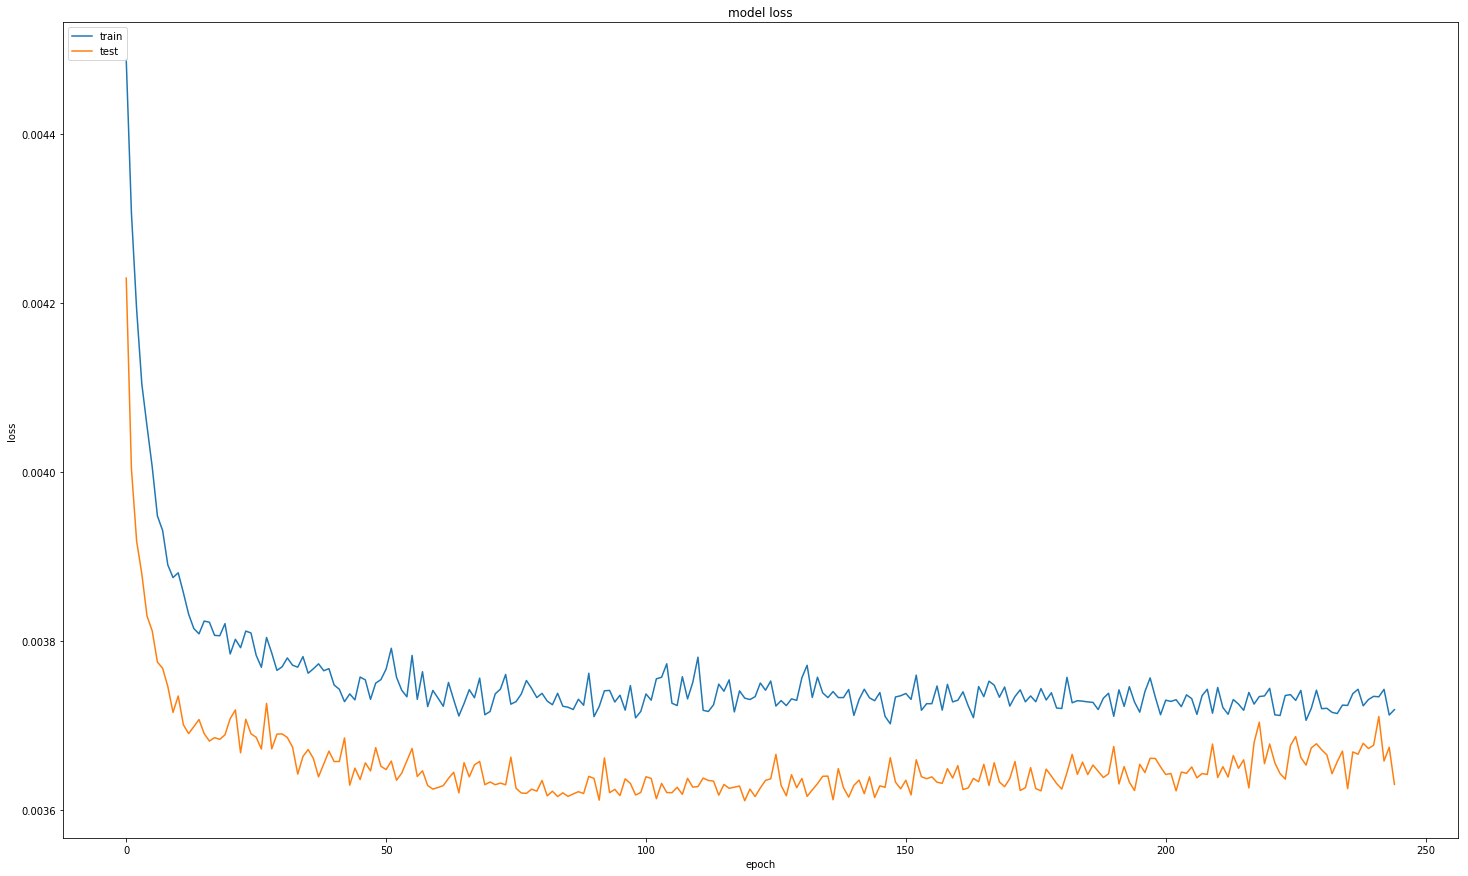

In [50]:
fig = plt.figure(figsize=(25, 15))
plt.plot(trained_lstm2.history['loss'][5:])
plt.plot(trained_lstm2.history['val_loss'][5:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
#plt.savefig('model_loss.png')
plt.show()

In [4]:
en_lstm_de_model_bs64 = load_model('en_lstm_de_model_bs64.h5')

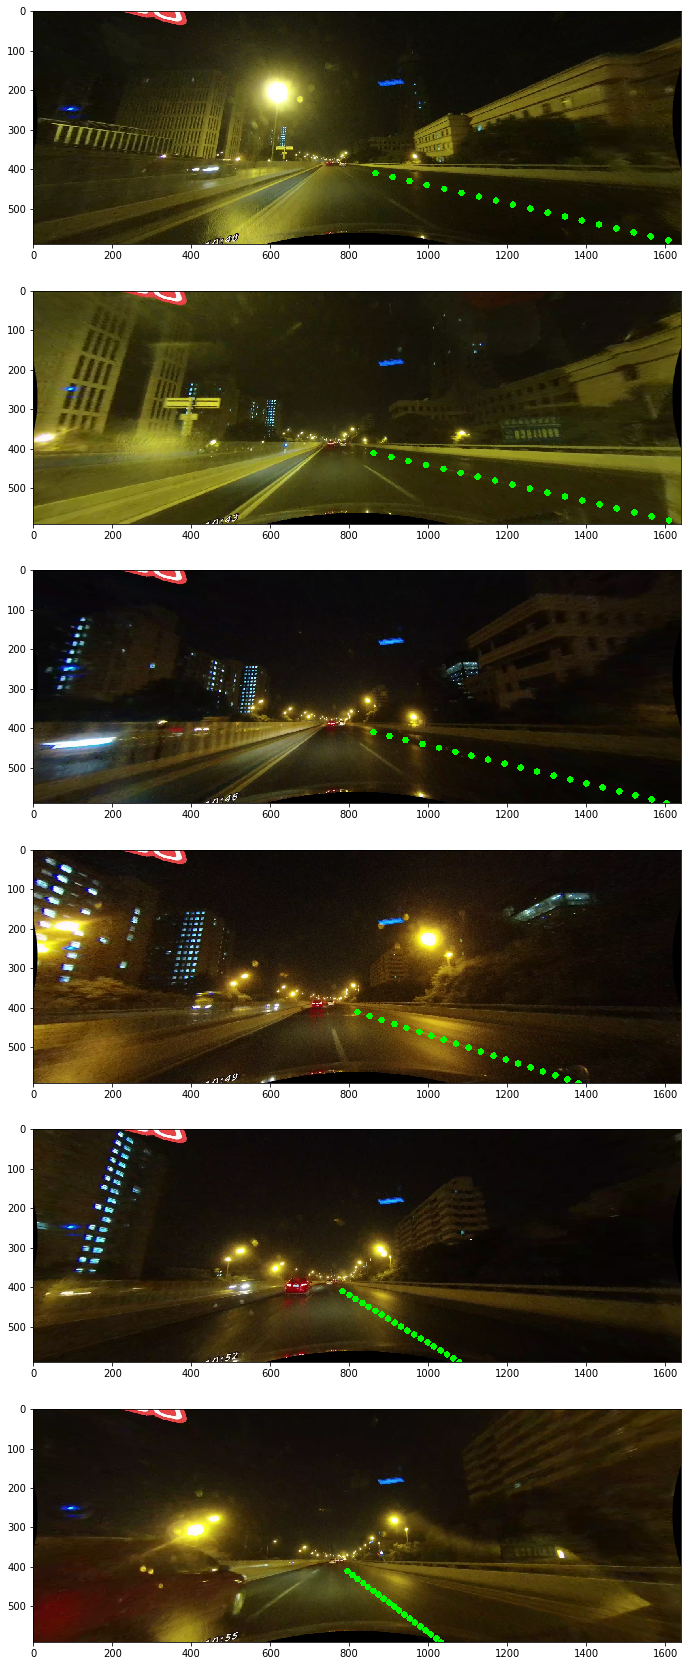

In [41]:
seq = 1026

u1 = (test_x[seq, 0] * 1640).astype(int)
v1 = np.arange(410, 600, 10)
line_data1 = np.concatenate(([u1], [v1])).transpose()

u2 = (test_x[seq, 1] * 1640).astype(int)
v2 = np.arange(410, 600, 10)
line_data2 = np.concatenate(([u2], [v2])).transpose()

u3 = (test_x[seq, 2] * 1640).astype(int)
v3 = np.arange(410, 600, 10)
line_data3 = np.concatenate(([u3], [v3])).transpose()

u4 = (test_x[seq, 3] * 1640).astype(int)
v4 = np.arange(410, 600, 10)
line_data4 = np.concatenate(([u4], [v4])).transpose()

u5 = (test_x[seq, 4] * 1640).astype(int)
v5 = np.arange(410, 600, 10)
line_data5 = np.concatenate(([u5], [v5])).transpose()

u6 = (test_y[seq] * 1640).astype(int)
v6 = np.arange(410, 600, 10)
line_data6 = np.concatenate(([u6], [v6])).transpose()
#print(line_data6)
#print(test_file_name[seq])

fig = plt.figure(figsize=(60, 30))
plt.subplot(6, 1, 1)
file_name = '../../LaneNet_train_set/' + test_file_name[seq, 0]
img1 = cv2.imread(file_name)
img1RGB = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
for point in line_data1[:]:
    cv2.circle(img1RGB, (point[0], point[1]), 4, (0, 255, 0), 8)
plt.imshow(img1RGB)

plt.subplot(6, 1, 2)
file_name = '../../LaneNet_train_set/' + test_file_name[seq, 1]
img2 = cv2.imread(file_name)
img2RGB = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
for point in line_data2[:]:
    cv2.circle(img2RGB, (point[0], point[1]), 4, (0, 255, 0), 8)
plt.imshow(img2RGB)

plt.subplot(6, 1, 3)
file_name = '../../LaneNet_train_set/' + test_file_name[seq, 2]
img3 = cv2.imread(file_name)
img3RGB = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
for point in line_data3[:]:
    cv2.circle(img3RGB, (point[0], point[1]), 4, (0, 255, 0), 8)
plt.imshow(img3RGB)

plt.subplot(6, 1, 4)
file_name = '../../LaneNet_train_set/' + test_file_name[seq, 3]
img4 = cv2.imread(file_name)
img4RGB = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)
for point in line_data4[:]:
    cv2.circle(img4RGB, (point[0], point[1]), 4, (0, 255, 0), 8)
plt.imshow(img4RGB)

plt.subplot(6, 1, 5)
file_name = '../../LaneNet_train_set/' + test_file_name[seq, 4]
img5 = cv2.imread(file_name)
img5RGB = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)
for point in line_data5[:]:
    cv2.circle(img5RGB, (point[0], point[1]), 4, (0, 255, 0), 8)
plt.imshow(img5RGB)

plt.subplot(6, 1, 6)
file_name = '../../LaneNet_train_set/' + test_file_name[seq, 5]
img6 = cv2.imread(file_name)
img6RGB = cv2.cvtColor(img6, cv2.COLOR_BGR2RGB)
for point in line_data6[:]:
    cv2.circle(img6RGB, (point[0], point[1]), 4, (0, 255, 0), 8)
plt.imshow(img6RGB)

0.02599930763244629
(590, 1640, 3)


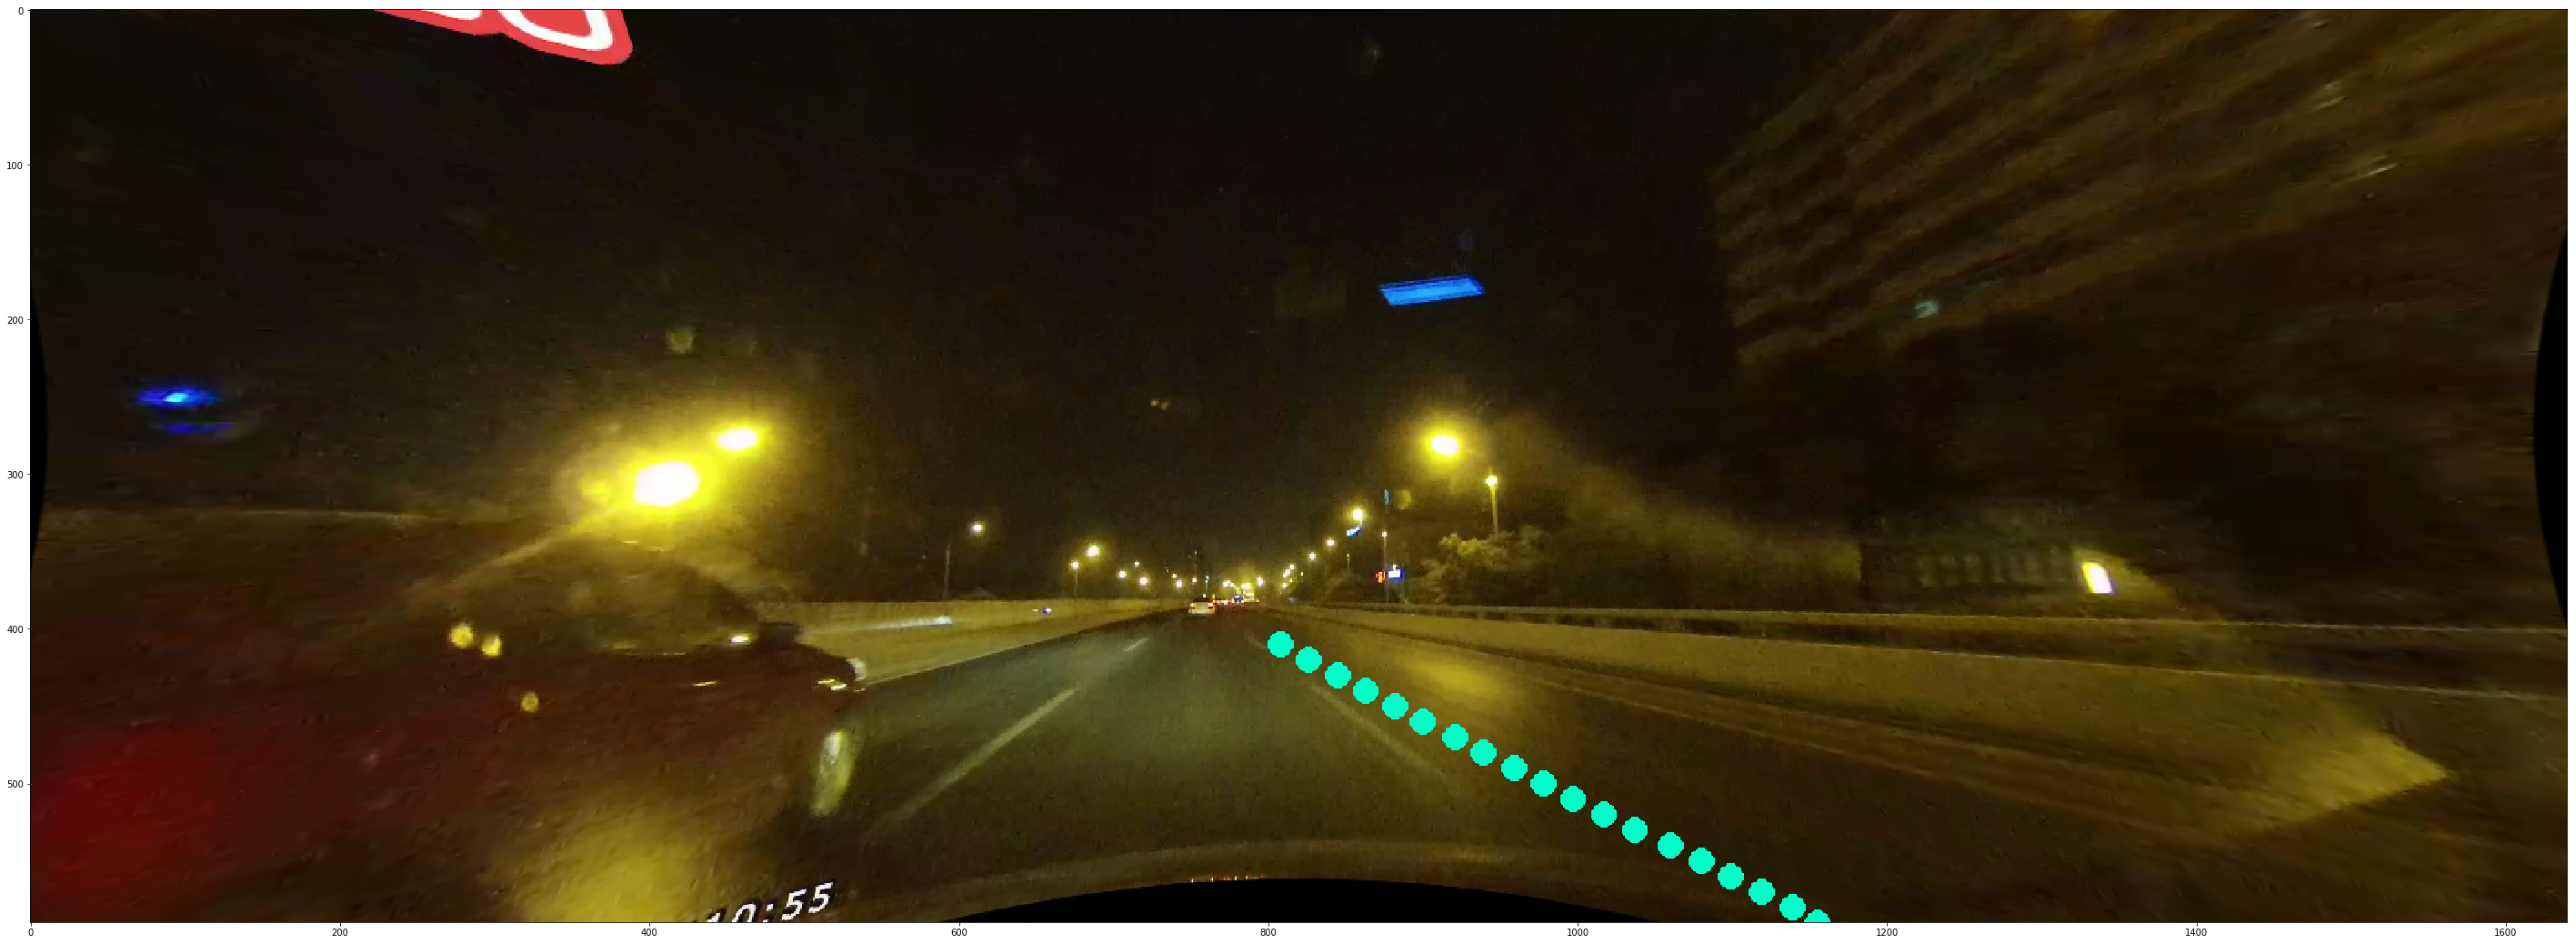

In [42]:
t_start = time.time()
nn_pred_y = (en_lstm_de_model_bs64.predict([test_x[seq].reshape((1, 5, 19)), \
                                            test_x[seq, :, 0].reshape((1, 5, 1)), \
                                            test_x[seq, :, -1].reshape((1, 5, 1))])).ravel()
t_cost = time.time() - t_start
print(t_cost)
#nn_pred_y = (en_lstm_de_model_bs64.predict(test_x[0].reshape((1, 5, 48)))).ravel()
#print(nn_pred_y)

u = (nn_pred_y * 1640).astype(int)
v = np.arange(410, 600, 10)
line_data = np.concatenate(([u], [v])).transpose()
#print(line_data)

fig = plt.figure(figsize=(50, 50))
file_name = '../../LaneNet_train_set/' + test_file_name[seq, 5]
img = cv2.imread(file_name)
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)

for point in line_data[:]:
    cv2.circle(imgRGB, (point[0], point[1]), 4, (0, 255, 200), 8)
    #cv2.putText(imgRGB, '({}, {})'.format(point[0], point[1]), (point[0], point[1]), \
    #            cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1, cv2.LINE_AA)
plt.imshow(imgRGB)

In [11]:
b = np.linspace(270, 419, 19).astype(int)
print(b)

[270 278 286 294 303 311 319 327 336 344 352 361 369 377 385 394 402 410
 419]
